# Anomality detection results


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# ARotor replication


In [2]:
data_folder = os.path.join(os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases")

support_data = pd.read_feather(
    os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "support_0.feather")
)
query_data = pd.read_feather(
    os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "query_0.feather")
)

print("support", support_data.shape)
print("query", query_data.shape)


support (3410, 67)
query (30607, 69)


## Figures


In [3]:
support_group = support_data[
    (support_data["rpm"] == 1500) & (support_data["GP"].isin([1, 2, 3, 4])) & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group = query_group.to_numpy()

query_group_2 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_2 = query_group_2.to_numpy()

query_group_3 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_3 = query_group_3.to_numpy()

query_group_4 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_4 = query_group_4.to_numpy()

query_group_5 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_5 = query_group_5.to_numpy()

query_group_6 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "8")
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_6 = query_group_6.to_numpy()


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/3833122620.py:18: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(tsne_embeddings, x="x", y="y", s=40, hue="class", palette=palette, alpha=1.0, legend=True)


<Axes: xlabel='x', ylabel='y'>

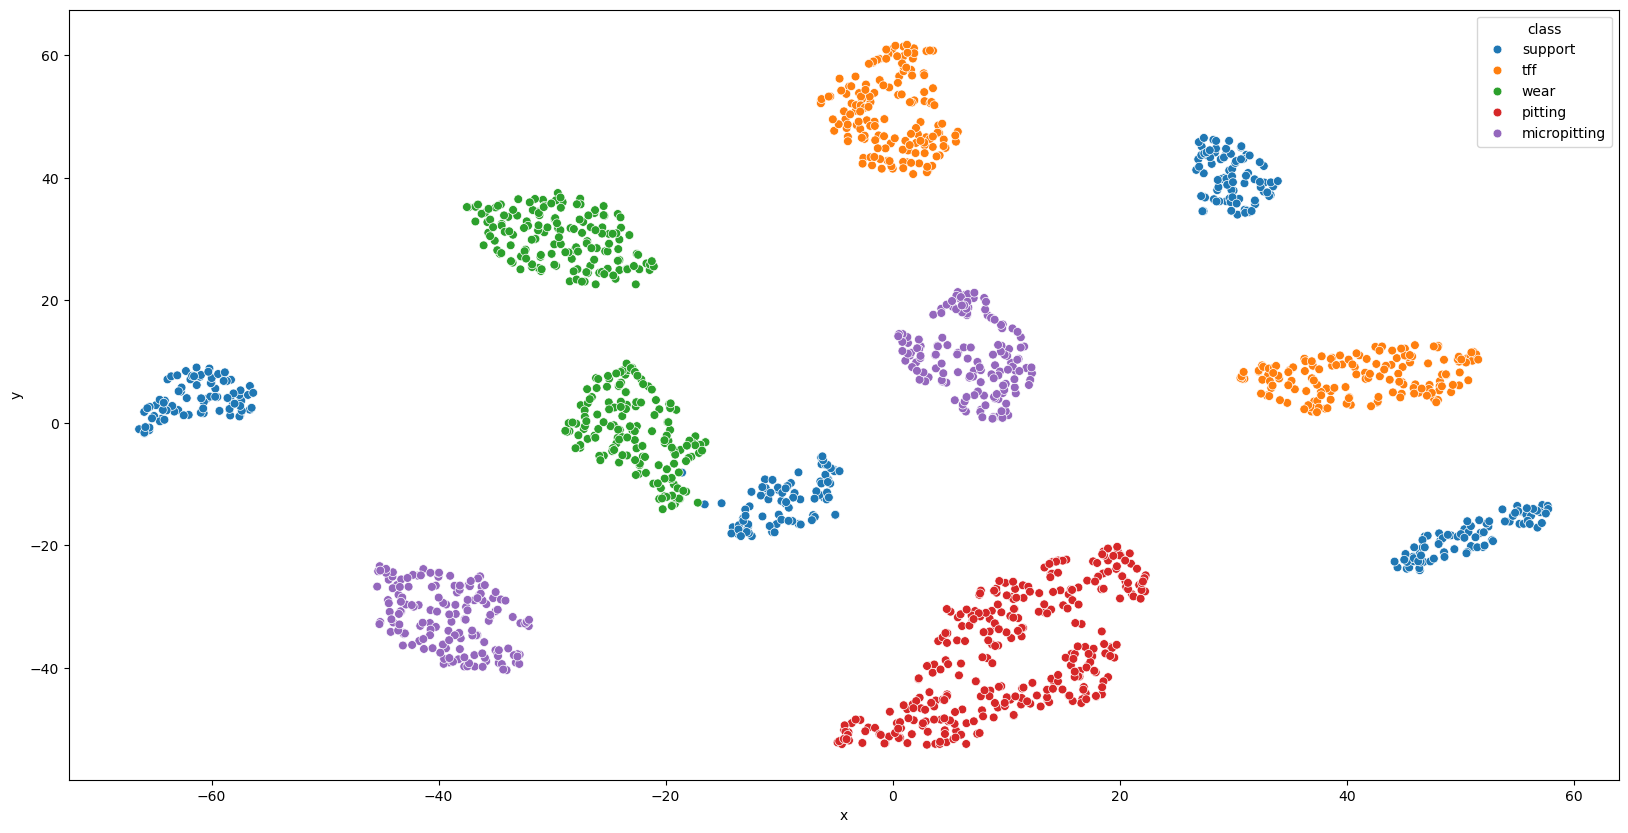

In [4]:
tsne_embeddings = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=20).fit_transform(
    np.concatenate([support_group, query_group, query_group_2, query_group_3, query_group_4])
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(tsne_embeddings, x="x", y="y", s=40, hue="class", palette=palette, alpha=1.0, legend=True)


In [5]:
tsne_embeddings = TSNE(n_components=3, learning_rate="auto", init="random", perplexity=20).fit_transform(
    np.concatenate([support_group, query_group, query_group_2, query_group_3, query_group_4])
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

fig = px.scatter_3d(tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200)
fig.show()


In [14]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(
    np.concatenate(
        [support_group, query_group_6, query_group, query_group_2, query_group_3, query_group_4, query_group_5]
    )
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group_6) * ["healthy"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
        len(query_group_5) * ["mild tff"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()


## Distance thresholding


In [7]:
support_group = support_data[
    (support_data["rpm"] == 1500) & (support_data["GP"].isin([1, 2, 3, 4])) & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = {}

query_group_baseline = query_data[
    (query_data["rpm"] == 1500)
    # & (query_data["severity"].isin(["5", "8", "9"]))
    # ! FIXME GPs 6 and 7 problematic why?
    & (query_data["severity"].isin(["5", "6", "7", "8", "9"]))
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["baseline"] = query_group_baseline.to_numpy()

query_group_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["tff"] = query_group_tff.to_numpy()

query_group_mild_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["mild_tff"] = query_group_mild_tff.to_numpy()

query_group_wear = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["wear"] = query_group_wear.to_numpy()

query_group_pitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["pitting"] = query_group_pitting.to_numpy()

query_group_micropitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["micropitting"] = query_group_micropitting.to_numpy()


### Raw distance


SUPPORT
Mean: 2828526.2
Max: 8897831.0
Min: 342565.06

baseline
Mean: 29422936.0
Max: 133728920.0
Min: 500292.03
mild_tff
Mean: 32074186.0
Max: 60860104.0
Min: 14862714.0
tff
Mean: 614225150.0
Max: 1276407900.0
Min: 218021470.0
micropitting
Mean: 135563760.0
Max: 332804580.0
Min: 15747299.0
pitting
Mean: 105508540.0
Max: 177519040.0
Min: 45807532.0
wear
Mean: 2471679.5
Max: 5935697.5
Min: 637606.1


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/2274576752.py:31: UserWarning:

The palette list has more values (12) than needed (7), which may not be intended.



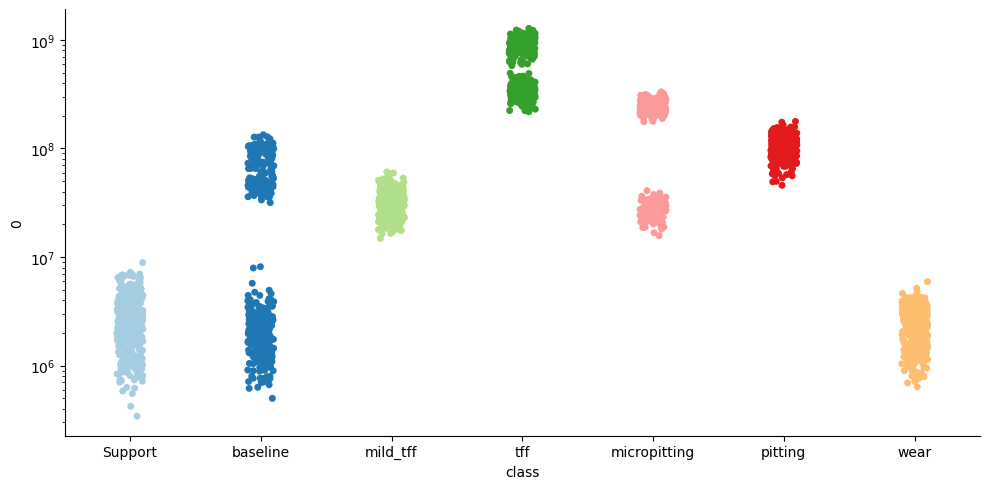

In [8]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum((query_group[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)


### STD scaled distance


SUPPORT
Mean: 62.90931
Max: 230.16695
Min: 11.542156

baseline
Mean: 444.02472
Max: 2480.921
Min: 15.9772625
mild_tff
Mean: 453.44962
Max: 1438.1573
Min: 180.03848
tff
Mean: 19925328.0
Max: 245907780.0
Min: 304059.94
micropitting
Mean: 1964.343
Max: 6148.272
Min: 177.23363
pitting
Mean: 1564.6053
Max: 14985.157
Min: 601.24414
wear
Mean: 68.76659
Max: 119.23784
Min: 21.766294


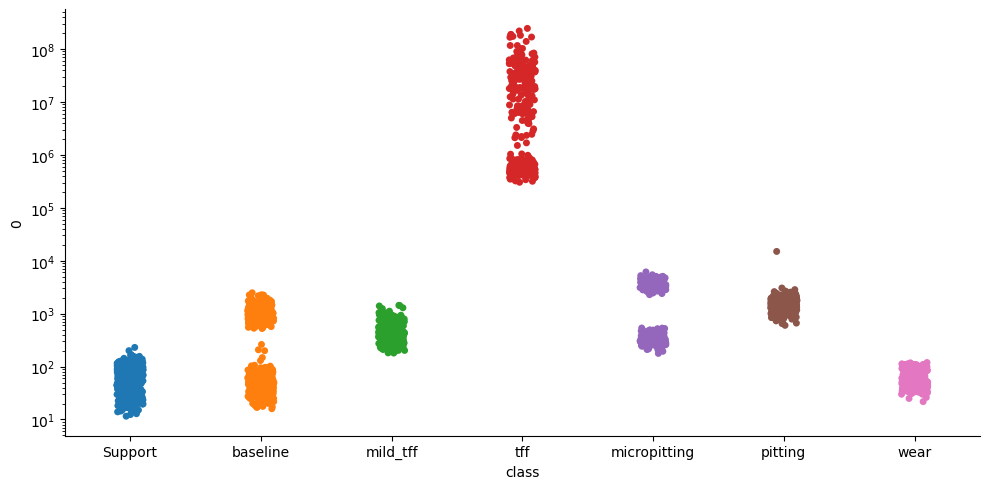

In [9]:
prototype = support_group.mean(axis=0)
prototype_std = support_group.std(axis=0)

prototype_std += 0.01  # Some stds are 0

print("SUPPORT")
support_distances = np.sum(((support_group - prototype) / prototype_std) ** 2, axis=1)
# support_distances = support_distances / prototype_std
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(((query_group[fault] - prototype) / prototype_std) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False)


### Distance after PCA


(341, 5)
(5,)
SUPPORT
Mean: 2732163.5
Max: 8851423.0
Min: 238410.69

baseline
Mean: 28785794.0
Max: 131959650.0
Min: 326157.88

mild_tff
Mean: 31625888.0
Max: 60629028.0
Min: 14641863.0

tff
Mean: 547478100.0
Max: 1151653200.0
Min: 191748300.0

micropitting
Mean: 134282380.0
Max: 329971200.0
Min: 15494750.0

pitting
Mean: 103992480.0
Max: 175379360.0
Min: 44831784.0

wear
Mean: 2251990.0
Max: 5515509.5
Min: 470289.7



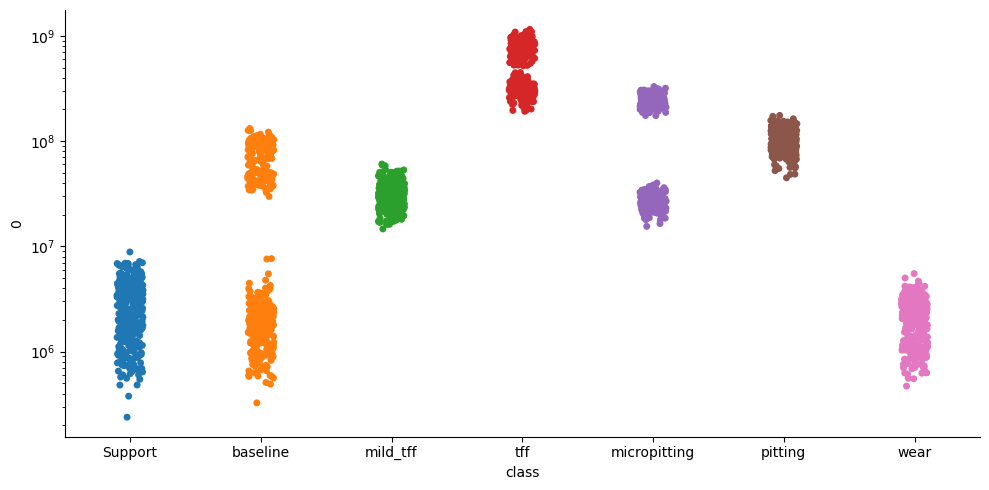

In [10]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum((pca.transform(query_group[fault]) - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False)


# ARotor


In [11]:
data_folder = os.path.join(os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases")

support_data = pd.read_feather(
    os.path.join(data_folder, "anomality_detection_arotor_10-18_17-35-55", "support_0.feather")
)
query_data = pd.read_feather(os.path.join(data_folder, "anomality_detection_arotor_10-18_17-35-55", "query_0.feather"))

print("support", support_data.shape)
print("query", query_data.shape)


support (208, 66)
query (3952, 66)


In [12]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(["rpm", "class"], axis=1)
support_group = support_group.to_numpy()

query_groups = {}

for i in range(10):
    query_group = query_data[(query_data["rpm"] == 1500) & (query_data["class"] == i)].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()


(52, 64)
(104, 64)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/1751696896.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

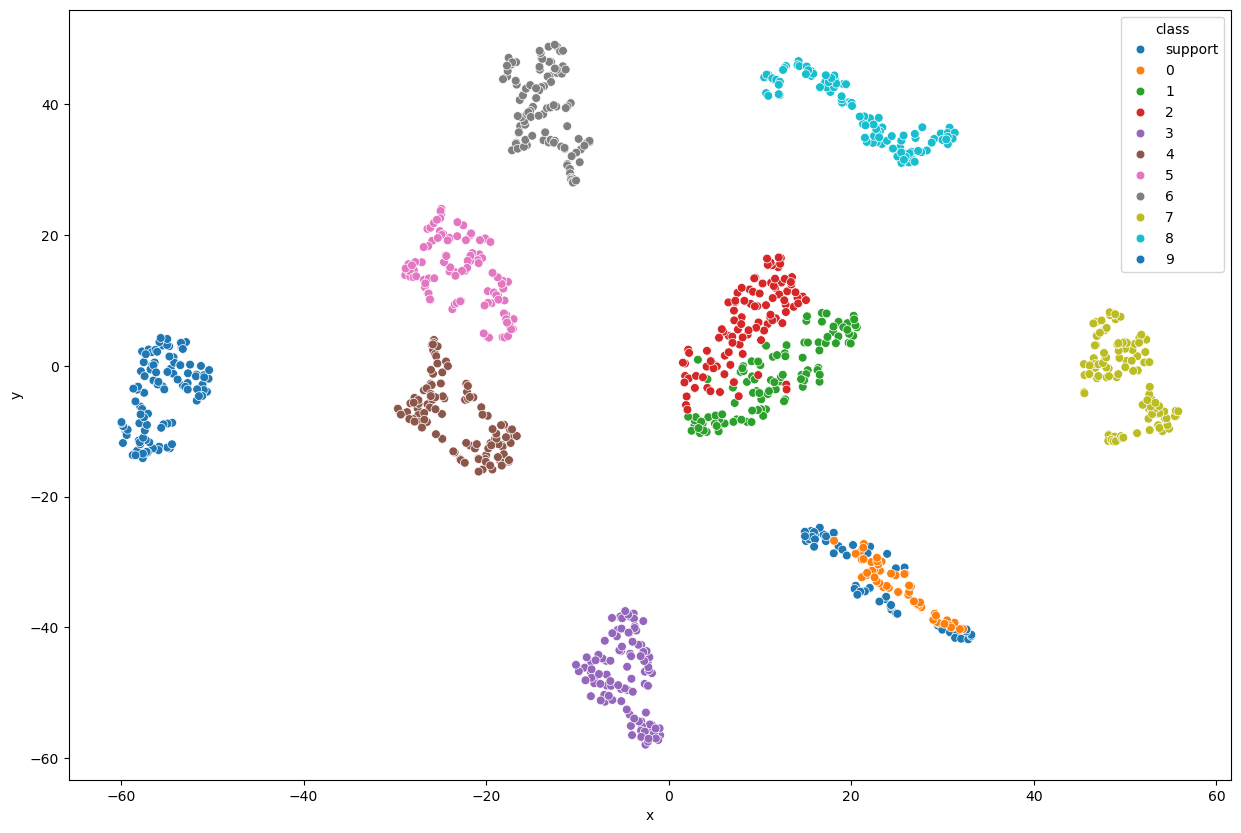

In [13]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=20).fit_transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(tsne_embeddings, x="x", y="y", s=40, hue="class", palette=palette, alpha=1.0, legend=True)


In [ ]:
tsne_embeddings = TSNE(n_components=3, learning_rate="auto", init="random", perplexity=20).fit_transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()


In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()


In [ ]:
str(sns.color_palette().as_hex())


"['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']"

### Distances


In [ ]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(["rpm", "class"], axis=1)
support_group = support_group.to_numpy()

query_group = {}

for i in range(10):
    query_group_baseline = query_data[(query_data["rpm"] == 1500) & (query_data["class"] == i)].drop(
        ["rpm", "class"], axis=1
    )
    query_group["baseline"] = query_group_baseline.to_numpy()


SUPPORT
Mean: 6542.1953
Max: 30318.348
Min: 863.4813

0
Mean: 3713.5776
Max: 12462.372
Min: 1637.6204
1
Mean: 4100191.5
Max: 5851580.5
Min: 3012762.5
2
Mean: 4396277.0
Max: 6185351.5
Min: 3020712.0
3
Mean: 1794723.2
Max: 2658541.0
Min: 1046323.3
4
Mean: 184759.08
Max: 486035.88
Min: 98558.4
5
Mean: 470167.78
Max: 906059.9
Min: 184549.25
6
Mean: 928152.94
Max: 1499536.9
Min: 396398.88
7
Mean: 241784.47
Max: 411656.22
Min: 87098.234
8
Mean: 532484.8
Max: 818234.75
Min: 352948.75
9
Mean: 1229076.9
Max: 1843879.2
Min: 853211.1


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_56158/3284075337.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



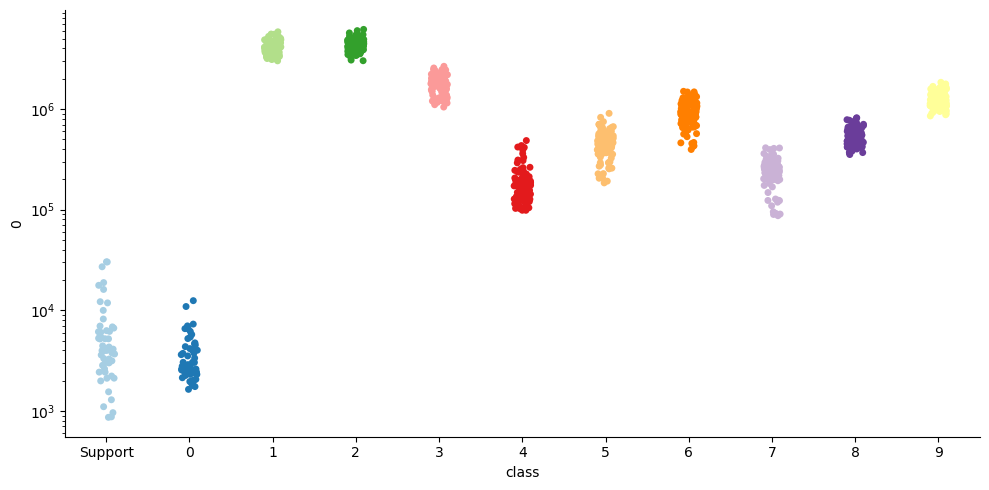

In [ ]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)


(52, 5)
(5,)
SUPPORT
Mean: 6171.154
Max: 30053.492
Min: 557.91754

0
Mean: 2737.9983
Max: 11904.995
Min: 675.12946

1
Mean: 3810128.2
Max: 5371965.0
Min: 2813731.0

2
Mean: 4028095.5
Max: 5539995.0
Min: 2785049.0

3
Mean: 1663222.6
Max: 2454545.0
Min: 979221.3

4
Mean: 168045.5
Max: 458705.03
Min: 84806.29

5
Mean: 425348.7
Max: 806707.44
Min: 166935.22

6
Mean: 771405.9
Max: 1308005.4
Min: 326110.62

7
Mean: 210900.72
Max: 371079.72
Min: 76442.47

8
Mean: 351590.8
Max: 626976.1
Min: 205615.33

9
Mean: 816633.75
Max: 1276034.9
Min: 562547.8



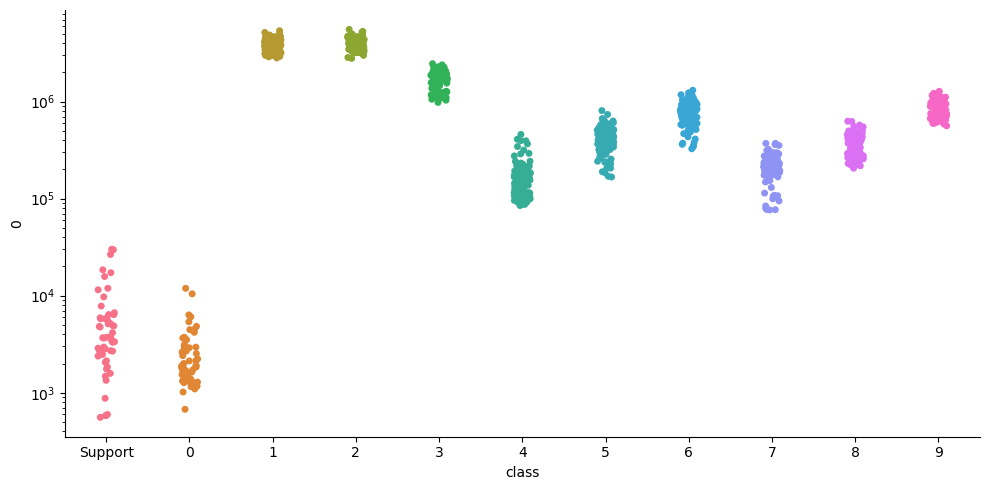

In [ ]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((pca.transform(query_groups[fault]) - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False)
